In [1]:
# Imports
import os 
import cv2
import numpy as np
import tensorflow as tf 

from object_detection.utils import label_map_util, visualization_utils, config_util
from object_detection.builders import model_builder

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
# Define data paths 
DATA_PATHS = {
    "pipeline_config": "model_checkpoints/pipeline.config", 
    "checkpoints_dir": "model_checkpoints/",
    "label_map_path": "tf_downloads/tf_annotations/label_map.pbtxt", 
    "test_image": "inference/4c105111-384a-4c02-9dd8-2d851097e41f-pursuit_s_378.jpg"    
}

### Load inference setup 

In [3]:
# Load checkpoints and configs
configs = config_util.get_configs_from_pipeline_file(DATA_PATHS['pipeline_config'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(DATA_PATHS['checkpoints_dir'], 'ckpt-2')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [4]:
# Load label map configs
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=label_map_util.get_max_label_map_index(label_map), use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

### Inference

[[[ 95  75  10]
  [ 94  74   9]
  [ 93  73   8]
  ...
  [ 97  73  15]
  [ 97  73  15]
  [ 98  74  16]]

 [[101  79  21]
  [ 99  80  19]
  [101  80  19]
  ...
  [ 95  73  15]
  [ 96  72  14]
  [ 93  71  13]]

 [[108  85  37]
  [107  86  35]
  [107  84  34]
  ...
  [ 86  66   8]
  [ 87  65   7]
  [ 85  65   7]]

 ...

 [[181 165 148]
  [185 169 152]
  [188 172 155]
  ...
  [ 72  61   9]
  [ 72  59   7]
  [ 70  59   7]]

 [[184 168 151]
  [188 172 155]
  [192 176 159]
  ...
  [ 71  60   8]
  [ 70  59   7]
  [ 69  58   6]]

 [[189 173 156]
  [193 177 160]
  [196 180 163]
  ...
  [ 70  59   7]
  [ 69  58   6]
  [ 68  57   5]]]
(307, 660, 3)
(1, 307, 660, 3)
INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


INFO:tensorflow:depth of additional conv before box predictor: 0


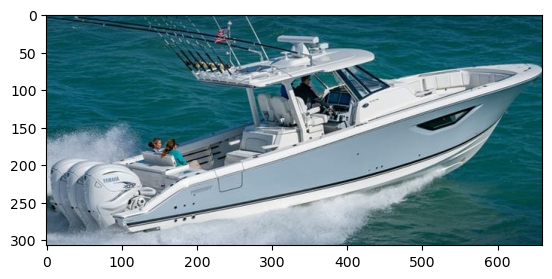

In [5]:
img = cv2.imread(DATA_PATHS["test_image"])
print(img)

image_np = np.array(img)

print(image_np.shape)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
print(input_tensor.shape)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

visualization_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()